# Лабораторная работа №1-2 по СМАД

## Тема: генерация экспериментальных данных по схеме имитационного моделирования на ЭВМ

---

## Вариант 2

Информация о моделируемом объекте:

-   число факторов - 2
-   По первому фактору зависимость близка к линейной (возрастающей)
-   По второму фактору зависимость близка к параболической
-   Максимальное значение отклика приходится на граничные точки точки области действия факторов

## Задание:

### Часть 1:

1. Определить модель, область действия факторов, план эксперимента
2. Написать программу по генерации экспериментальных данных
3. Построить графики зависимости незашумленного отклика от входных факторов

### Часть 2:

1. Сформировать программные модули по вычислению МНК-оценок параметров для заданной параметрической модели
2. Оценить параметры модели объекта
3. Проверить адекватность полученной модели.


Импортируем нужные библиотеки


In [297]:
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import scipy.stats as scp


Задаем класс Модель

Параметры модели $\theta$ = [1, 4, 0.001, 4]


In [298]:
class Model:

    def __init__(self):
        self.amount_tests = 12
        self.x_max = 1
        self.x_min = -1
        self.x1 = []
        self.x2 = []
        self.signal = []
        self.response = []
        self.response_hat = []
        self.power = 0
        self.variance = 0
        self.theta = [1, 4, 0.001, 4]
        self.func = lambda x1, x2: 1 + 4*x1 + 0.001 * x1 ** 2 + 4 * x2 ** 2


In [299]:
class Calculator:

    @staticmethod
    def compute_signal(model: Model):
        signal = [model.func(model.x1[i], model.x2[i])
                  for i in range(model.amount_tests)]
        return np.array(signal)

    @staticmethod
    def compute_variance(model) -> float:
        return model.power * 0.1

    @staticmethod
    def compute_power(model):
        avg_signal = [
            np.sum(model.signal) / len(model.signal)
            for i in range(len(model.signal))
        ]
        vec_avg_signal = np.array(avg_signal)
        power = np.vdot(model.signal - vec_avg_signal,
                        model.signal - vec_avg_signal) / len(model.signal)
        return power

    @staticmethod
    def compute_response(model, error):
        return model.signal + error


Создаем модуль генерации случайных значений

Первая функция генерирует пару независимых переменных.
Вторая функция генерирует величину ошибки с нормальным распределением и нулевым мат. ожиданием


In [300]:
class DataGenerator:

    @staticmethod
    def generate_couple(x_min, x_max, amount_tests):
        x1 = np.random.uniform(x_min, x_max, amount_tests)
        x2 = np.random.uniform(x_min, x_max, amount_tests)
        return x1, x2

    @staticmethod
    def generate_error(standard_deviation, number_tests) -> float:
        error = np.random.normal(0, standard_deviation, number_tests)
        return error


Заполняем модель данными


In [301]:
model = Model()

model.x1, model.x2 = DataGenerator.generate_couple(
    model.x_min, model.x_max, model.amount_tests)

model.signal = Calculator.compute_signal(model)
model.power = Calculator.compute_power(model)
model.variance = Calculator.compute_variance(model)

error = DataGenerator.generate_error(
    model.variance, model.amount_tests)

model.response = Calculator.compute_response(model, error)


Отрисовываем таблицу выборки и параметры модели


In [302]:
table = PrettyTable()
table.field_names = ["Num Test", "x1", "x2", "signal", "error", "response"]
for i in range(model.amount_tests):
    table.add_row([i+1, np.around(model.x1[i], 7),
                   np.around(model.x2[i], 7),
                   np.around(model.signal[i], 7),
                   np.around(error[i], 7),
                   np.around(model.response[i], 7)])
print(table)
print("\n")
print(f"Параметры модели Θ: {model.theta}")
print(f"Мощность сигнала: {model.power}")
print(f"Дисперсия σ: {model.variance}")


+----------+------------+------------+------------+------------+------------+
| Num Test |     x1     |     x2     |   signal   |   error    |  response  |
+----------+------------+------------+------------+------------+------------+
|    1     | -0.5814149 |  0.792225  | 1.1851602  | -0.4282271 | 0.7569331  |
|    2     | 0.2774681  | -0.9410328 | 5.6521207  | -0.3372869 | 5.3148338  |
|    3     | 0.1943347  | -0.8498085 | 4.6660747  | -0.5221735 | 4.1439012  |
|    4     | -0.5593579 | 0.4228051  | -0.5220622 | 0.2334007  | -0.2886615 |
|    5     |  0.879693  | -0.3572456 | 5.0300436  | 0.0029663  | 5.0330099  |
|    6     | 0.1944646  | 0.2873681  |  2.108218  | 0.0881823  | 2.1964003  |
|    7     | -0.606953  | 0.6219839  | 0.1200123  | 0.0926679  | 0.2126802  |
|    8     | -0.3334559 | 0.6204239  | 1.2059907  | -0.1697341 | 1.0362566  |
|    9     | -0.6286078 | 0.7717417  | 0.8683048  | -0.1055081 | 0.7627967  |
|    10    | 0.0018329  | 0.1335601  | 1.0786848  | 0.2718292  |

Построение графиков зависимости незашумленного отклика от входных параметров


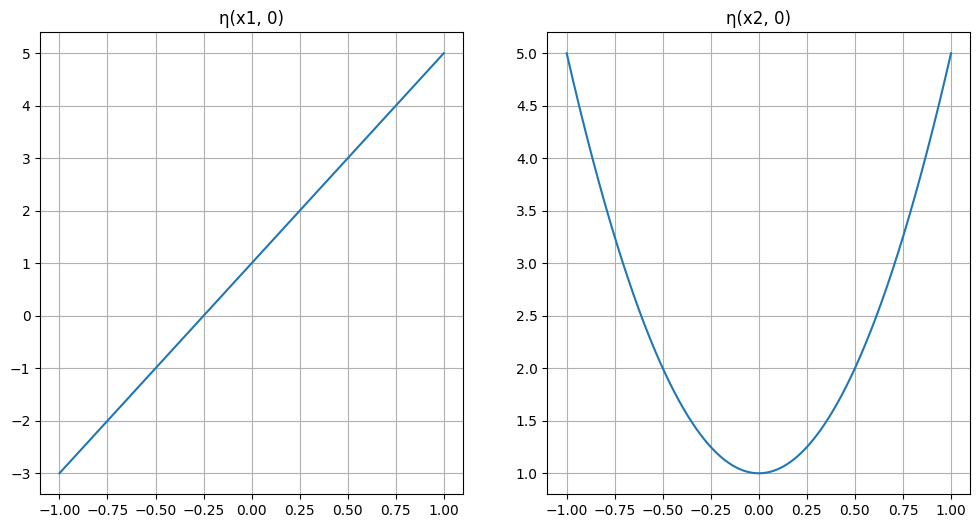

In [303]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax_x1 = np.linspace(-1, 1, 1000)
ax_x2 = ax_x1
axes[0].set(title="η(x1, 0)")
axes[1].set(title="η(x2, 0)")
axes[0].plot(ax_x1, model.func(ax_x1, 0))
axes[1].plot(ax_x2, model.func(0, ax_x2))
axes[0].grid()
axes[1].grid()
plt.show()


### Часть 2. Определение адекватности модели
***
Сначала определим матрицу наблюдений, где
$$ f(x) = (1, x_1, x_1^2, x_2^2) $$

In [304]:
experiment_matrix = np.array([
    np.array([1 for _ in range(model.amount_tests)]),
    model.x1,
    np.array([x1 ** 2 for x1 in model.x1]),
    np.array([x2 ** 2 for x2 in model.x2])
], dtype=object)
experiment_matrix = np.array([list(i) for i in zip(*experiment_matrix)])
print_experiment_matrix = PrettyTable()
for i in range(model.amount_tests):
    print_experiment_matrix.add_row([
    i+1, 
    np.around(experiment_matrix[i][0], 7),
    np.around(experiment_matrix[i][1], 7),
    np.around(experiment_matrix[i][2], 7),
    np.around(experiment_matrix[i][3], 7)
    ])
print_experiment_matrix.header=False
print("Матрица наблюдений Х:")
print(print_experiment_matrix)

Матрица наблюдений Х:
+----+-----+------------+-----------+-----------+
| 1  | 1.0 | -0.5814149 | 0.3380433 | 0.6276204 |
| 2  | 1.0 | 0.2774681  | 0.0769885 | 0.8855428 |
| 3  | 1.0 | 0.1943347  |  0.037766 | 0.7221745 |
| 4  | 1.0 | -0.5593579 | 0.3128813 | 0.1787641 |
| 5  | 1.0 |  0.879693  | 0.7738598 | 0.1276244 |
| 6  | 1.0 | 0.1944646  | 0.0378165 | 0.0825804 |
| 7  | 1.0 | -0.606953  |  0.368392 |  0.386864 |
| 8  | 1.0 | -0.3334559 | 0.1111928 | 0.3849258 |
| 9  | 1.0 | -0.6286078 | 0.3951478 | 0.5955852 |
| 10 | 1.0 | 0.0018329  |  3.4e-06  | 0.0178383 |
| 11 | 1.0 | 0.1639372  | 0.0268754 | 0.1927889 |
| 12 | 1.0 | 0.3760244  | 0.1413944 | 0.0038933 |
+----+-----+------------+-----------+-----------+


Далее вычислим МНК-оценки $\hat{\theta} = (X^T X)^{-1}X^Ty$

In [305]:
trans_experiment_matrix = experiment_matrix.T
mnk_eval = np.matmul(np.linalg.inv(np.matmul(trans_experiment_matrix, experiment_matrix)), trans_experiment_matrix)
mnk_eval = np.matmul(mnk_eval, model.response)
print("МНК-оценка Тета:")
print(mnk_eval)

МНК-оценка Тета:
[ 1.29884542  3.91950691 -0.02417574  3.07403788]


Найдем вектор остатков $\hat{e} = y - \hat{y} = y - X\hat{\theta}$

In [306]:
model.response_hat = np.dot(experiment_matrix, mnk_eval)
residual_vector = model.response - model.response_hat
print(residual_vector)

[-0.1842092   0.20811925 -0.13571923  0.06293665 -0.08741207 -0.11759164
  0.1124629  -0.13619437  0.1064854  -0.01035096 -0.08513892  0.26661218]


Найдем несмещенную оценку $\hat{\sigma}^2$ неизвестной дисперсии наблюдения
$$ \hat{\sigma}^2 = \hat{e}^T\hat{e} / (n-m)$$

In [307]:
disp: float = np.vdot(residual_vector.T, residual_vector) / (model.amount_tests - len(mnk_eval))
print(f"Несмещенная оценка неизвестной дисперсии равна: {disp}")

Несмещенная оценка неизвестной дисперсии равна: 0.03025872816035219


Итоговая таблица с данными модели:

In [308]:
final_table = PrettyTable()
final_table.field_names = ["№", "x1", "x2", "u", "y", "Ŷ", "y - Ŷ"]
for i in range(model.amount_tests):
    final_table.add_row([
        i+1,
        np.around(model.x1[i],7),
        np.around(model.x2[i],7),
        np.around(model.signal[i],7),
        np.around(model.response[i],7),
        np.around(model.response_hat[i],7),
        np.around(residual_vector[i], 7)
    ])
print(final_table)

+----+------------+------------+------------+------------+------------+------------+
| №  |     x1     |     x2     |     u      |     y      |     Ŷ      |   y - Ŷ    |
+----+------------+------------+------------+------------+------------+------------+
| 1  | -0.5814149 |  0.792225  | 1.1851602  | 0.7569331  | 0.9411423  | -0.1842092 |
| 2  | 0.2774681  | -0.9410328 | 5.6521207  | 5.3148338  | 5.1067145  | 0.2081193  |
| 3  | 0.1943347  | -0.8498085 | 4.6660747  | 4.1439012  | 4.2796204  | -0.1357192 |
| 4  | -0.5593579 | 0.4228051  | -0.5220622 | -0.2886615 | -0.3515981 | 0.0629366  |
| 5  |  0.879693  | -0.3572456 | 5.0300436  | 5.0330099  | 5.1204219  | -0.0874121 |
| 6  | 0.1944646  | 0.2873681  |  2.108218  | 2.1964003  | 2.3139919  | -0.1175916 |
| 7  | -0.606953  | 0.6219839  | 0.1200123  | 0.2126802  | 0.1002173  | 0.1124629  |
| 8  | -0.3334559 | 0.6204239  | 1.2059907  | 1.0362566  |  1.172451  | -0.1361944 |
| 9  | -0.6286078 | 0.7717417  | 0.8683048  | 0.7627967  | 0.6563

Теперь проверим гипотезу об адекватности модели:
Гипотеза не отвергается, если отношение оценок дисперсий на основе МНК к полученной без использования модели меньше либо равно табличному значению квантили F-распределения.

In [309]:
quantile: float = scp.f.ppf(0.95, model.amount_tests - len(mnk_eval), 1e+10)
print(f"Значение квантили распределения равно {quantile}")
if disp / model.variance <= quantile:
    print("Гипотеза не отвергается")
else:
    print("Гипотеза отвергается. Модель неадекватна.")

Значение квантили распределения равно 1.938414154420451
Гипотеза не отвергается
